# Imports

In [ ]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn import tree
import sklearn.cluster as cluster
from sklearn.metrics import accuracy_score, pairwise
from sklearn.linear_model import LinearRegression, LogisticRegression
import plotly.express as px
import plotly.graph_objects as go
from scipy.optimize import minimize

np.random.seed(1234)

In [ ]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update({"axes.grid": True, "figure.figsize": (8, 4)})
import seaborn as sns

sns.set()

# 16.1 Non-Linear Features in Classifiers

In [ ]:
data = datasets.load_wine()
wine = pd.DataFrame(data.data, columns=data.feature_names)
wine["class"] = data.target
wine

In [ ]:
features = ["total_phenols", "color_intensity", "class"]
wine = wine[features]
wine

In [ ]:
wine.value_counts()

In [ ]:
sns.scatterplot(
    data=wine, x=wine["total_phenols"], y=wine["color_intensity"], hue="class"
)

Generate the non-linear features hand-coded

In [ ]:
x0, x1 = "total_phenols", "color_intensity"
X = wine[[x0, x1]]
X["phi0"] = X[x0] * X[x1]
X["phi1"] = X[x0] * X[x0]
X["phi2"] = X[x1] * X[x1]
X

In [ ]:
y = wine["class"]

In [ ]:
lr = LogisticRegression(multi_class="multinomial").fit(X, y)
accuracy_score(y, lr.predict(X)) * 100.0

In [ ]:
X1 = X[["total_phenols", "color_intensity"]]
lgr = LogisticRegression(multi_class="multinomial").fit(X1, y)

xx = np.linspace(X1.iloc[:, 0].min(), X1.iloc[:, 0].max(), 50)
yy = np.linspace(X1.iloc[:, 1].min(), X1.iloc[:, 1].max(), 50)
XX, YY = np.meshgrid(xx, yy)
grid = np.c_[XX.ravel(), YY.ravel()]
labels = pd.factorize(lgr.predict(grid))[0]

plt.contourf(xx, yy, labels.reshape(XX.shape), cmap="tab10", alpha=0.3)
sns.scatterplot(
    data=X1, x="total_phenols", y="color_intensity", hue=y, palette="bright"
)

Can also try other non-linear features, including higher-order polynomial terms and others. Below is a sample of various additional features added

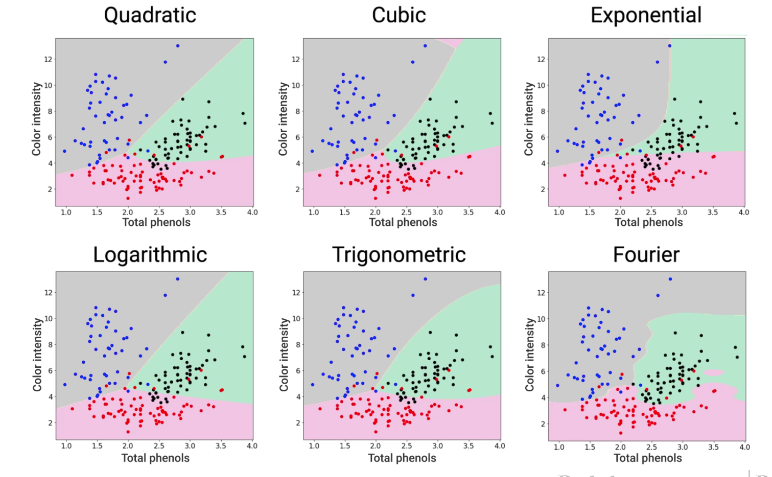

But this space of possible non-linear features is inifinite, so how to choose?
- Use intuition to choose stuff you think should work
- Try many and use lasso to compress away the non-helpful ones
- Use a kernel representation - next video has the details

# The Kernel Trick

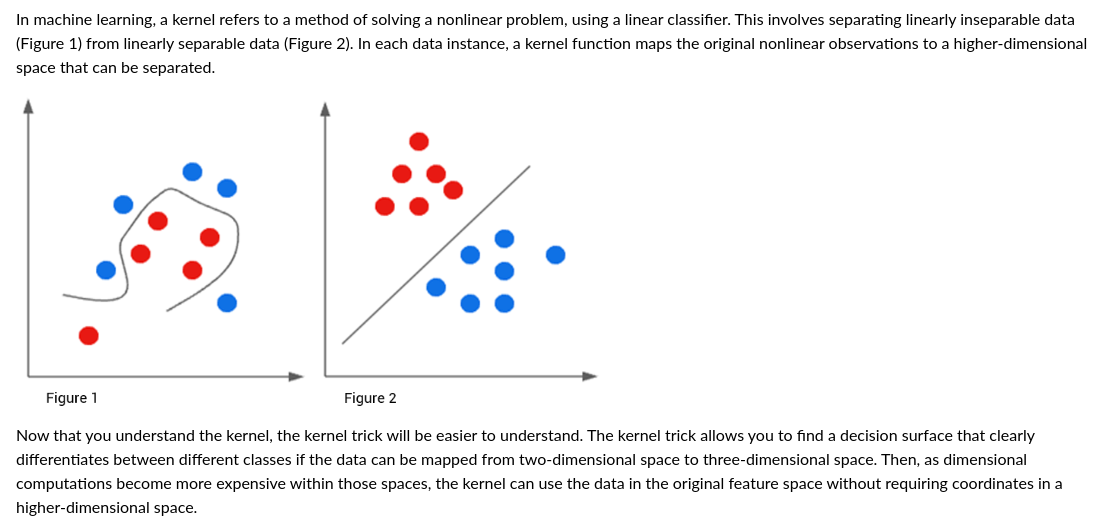

# 16.2 The Kernel Trick

Kernel is a function that takes 2 vectors as inputs and returns a number

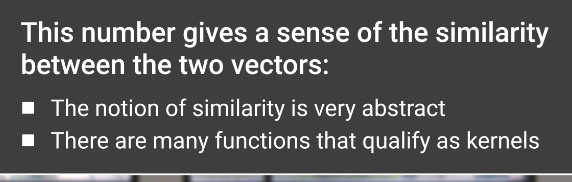

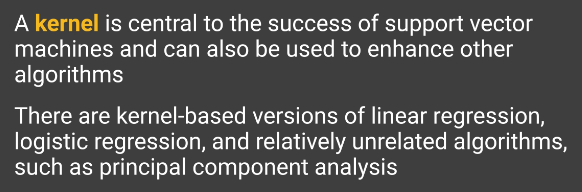

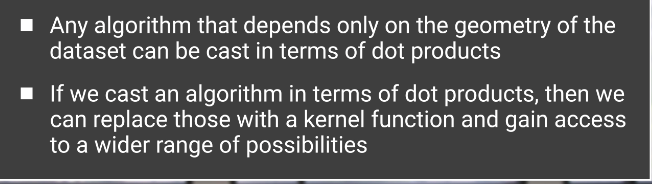

phi is some non-linear feature transformation

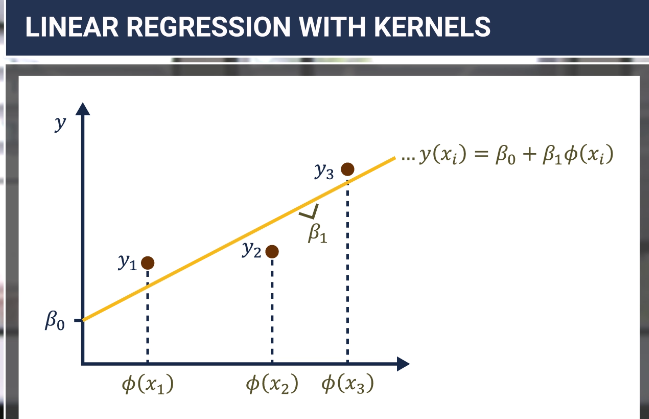

Written in vector notation

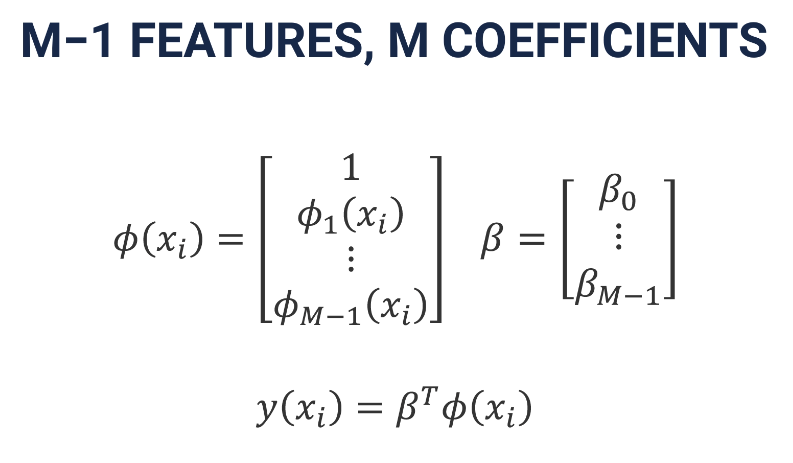

In the above, there is one phi for every feature M. Now, rewrite in terms of alpha parameters, with one alpha per observation (i)

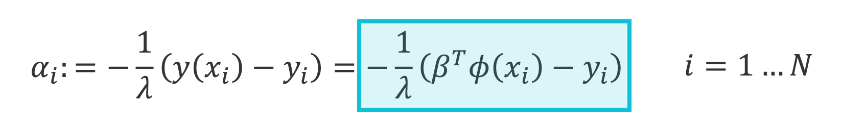

Relating alpha back to beta in vector notation

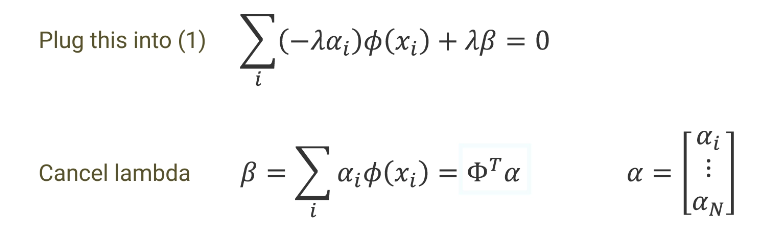

And in matrix form:

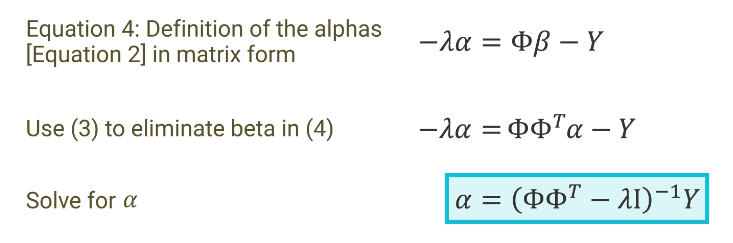

Comparing expressions for optimal alpha and beta
- Notice that alpha requires an NxN matrix (N = number of observations)
- Whereas beta requires inverting an MxM matrix (M = number of features)
- In general, N >> M, so on the face of it, beta seems an easier route thana alpha
- But...

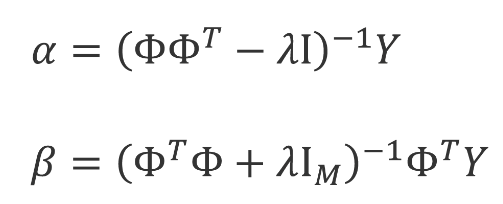

How to make a prediction with alpha and beta?
- Compare the following expressions
- Notice that when using alpha, you need all the training data (xi)
- Whereas with beta you do not

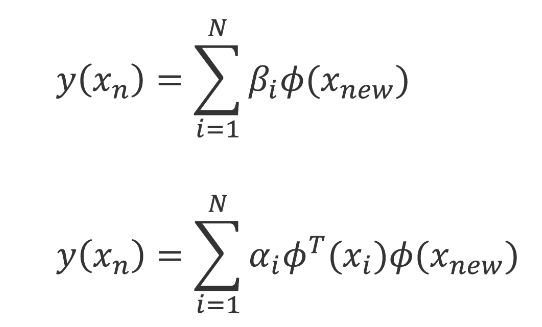

Looking at the matrix K - the Kernel matrix

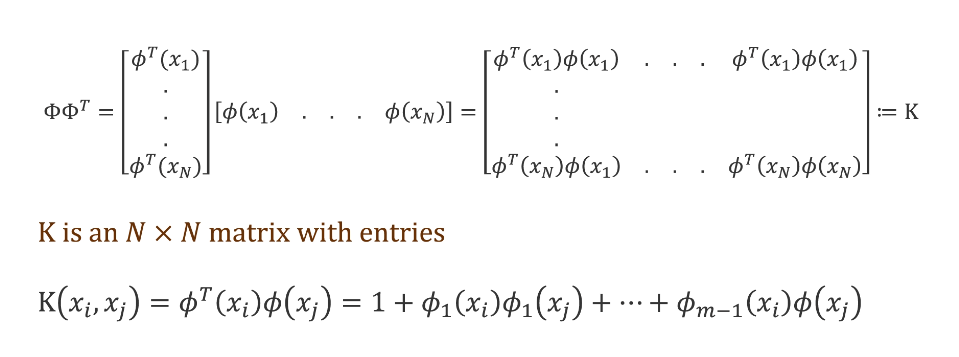

The Kernel function k takes a pair of xi, xj and returns the inner (dot) product <phi(xi),phi(xj)>

Now update the prediction equation using kernel function
- Now the prediction is viewed as a weighted sum of the kernel functions
- With alpha being the weights

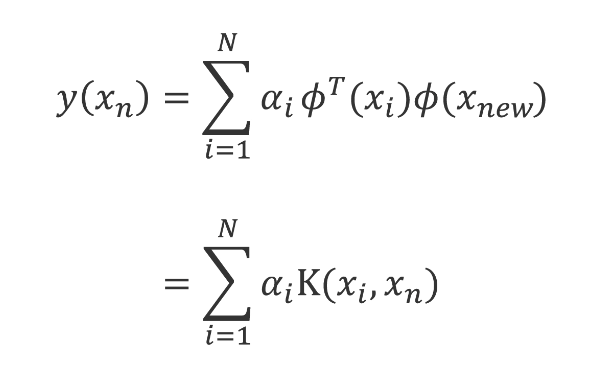

# 16.3 Kernels in Code

Comparing feature vs. kernel based parameters for regression

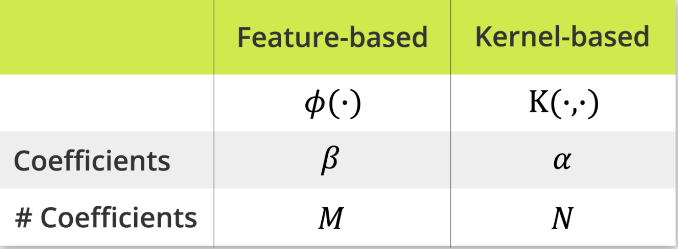

Training differences, first look at beta (standard)

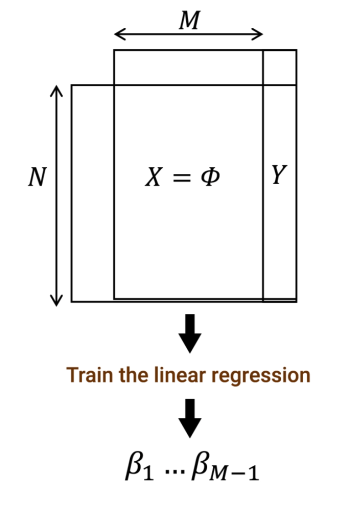

Then look at alpha

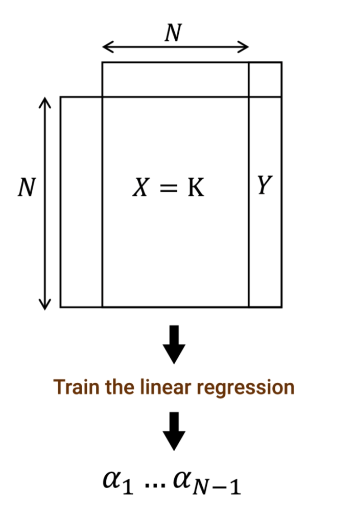

## Sample Data Set

In [ ]:
def sample_y_func(X):
    return np.cos(X) + 0.1 * np.random.randn(X.shape[0])

In [ ]:
def sample_data(N):
    X = 2 * np.pi * np.random.rand(N)
    Y = sample_y_func(X)
    return {"X": X.reshape(-1, 1), "Y": Y}, pd.DataFrame({"X": X, "Y": Y})

In [ ]:
np.random.seed(34985)
N = 20
train, dftrain = sample_data(N)
display(dftrain.head())

Ntest = 5
test, dftest = sample_data(Ntest)

X_demo = np.linspace(train["X"].min(), train["X"].max(), 101).reshape(-1, 1)
Y_demo = sample_y_func(X_demo.ravel())

In [ ]:
plt.scatter(train["X"], train["Y"], label="train")
plt.plot(X_demo, Y_demo, label="Smooth Line", color="black")

## Helper Functions

### Make Kernel Matrix

Given a kernel function and a training matrix X

In [ ]:
def make_kernel_matrix(kfunc, X):
    N, _ = X.shape
    K = np.empty((N, N))
    for i in range(N):
        for j in range(N):
            K[i, j] = kfunc(X[i, :], X[j, :])

    return K

### Make a Prediction from a Kernel Fitted Model

Seems like this function could be modified to use the kernel matrix generator above

In [ ]:
def make_kernel_prediction(model, kfunc, X_train, X_test):
    # Make kernel matrix
    N1, _ = X_train.shape
    N2, _ = X_test.shape
    K = np.empty((N2, N1))
    for i in range(N2):
        for j in range(N1):
            K[i, j] = kfunc(X_train[j, :], X_test[i, :])

    # Pass to model predict
    return model.predict(K)

## Linear Kernel

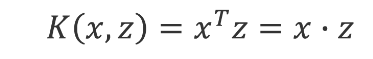

In [ ]:
def linear_kernel_function(x, z):
    return np.dot(x, z)

### Build the kernel matrix for a given data set

Note inclusion of small identity matrix lambda*I

In [ ]:
Kl = make_kernel_matrix(linear_kernel_function, train["X"]) + 0.1 * np.eye(N)

### Now perform linear regression using Kernel matrix, not original data set

In [ ]:
linear_model = LinearRegression().fit(Kl, train["Y"])
linear_model.coef_

### Predict with Kernel Method

In [ ]:
y_pred = make_kernel_prediction(
    linear_model, linear_kernel_function, train["X"], test["X"]
)
y_demo = make_kernel_prediction(
    linear_model, linear_kernel_function, train["X"], X_demo
)

In [ ]:
plt.scatter(train["X"], train["Y"], label="train")
plt.scatter(test["X"], test["Y"], label="test")
plt.scatter(test["X"], y_pred, label="train-fit")
plt.plot(X_demo, y_demo, label="Line of Fit", color="black")
plt.legend()

## Quadratic Kernel

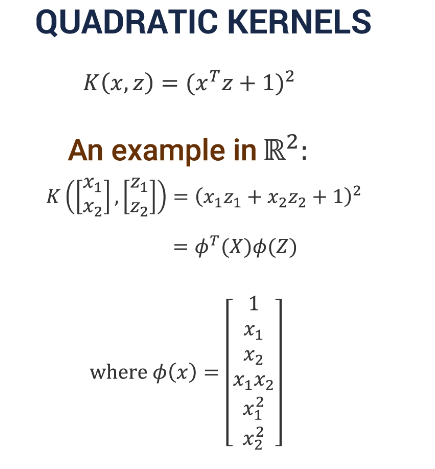

### Try it in Code

Only need to make a new kernel function

In [ ]:
def quadratic_kernel_function(x, z):
    return (np.dot(x, z) + 1) ** 2

In [ ]:
Kq = make_kernel_matrix(quadratic_kernel_function, train["X"]) + 0.1 * np.eye(N)
quadratic_model = LinearRegression().fit(Kq, train["Y"])
yhat_test_q = make_kernel_prediction(
    quadratic_model, quadratic_kernel_function, train["X"], test["X"]
)
yhat_demo_q = make_kernel_prediction(
    quadratic_model, quadratic_kernel_function, train["X"], X_demo
)

In [ ]:
plt.scatter(train["X"], train["Y"], label="train")
plt.scatter(test["X"], test["Y"], label="test")
plt.scatter(test["X"], yhat_test_q, label="Quadratic Kernel Prediction")
plt.plot(X_demo, yhat_demo_q, label="Line of Fit", color="black")
plt.legend()

## Polynomial Kernels

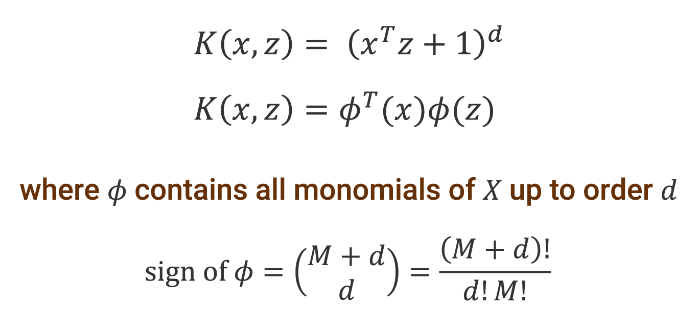

Instead of hand-coding this, we can use sklearn functions

In [ ]:
Kp = pairwise.polynomial_kernel(train["X"], train["X"], degree=3) + 0.1 * np.eye(N)
pairwise_model = LinearRegression().fit(Kp, train["Y"])

In [ ]:
yhat_test_p = pairwise_model.predict(
    pairwise.polynomial_kernel(test["X"], train["X"], degree=3)
)

yhat_demo_p = pairwise_model.predict(
    pairwise.polynomial_kernel(X_demo, train["X"], degree=3)
)

In [ ]:
plt.scatter(train["X"], train["Y"], label="train")
plt.scatter(test["X"], test["Y"], label="test")
plt.scatter(test["X"], yhat_test_p, label="Polynomial Kernel Prediction")
plt.plot(X_demo, yhat_demo_p, label="Line of Fit", color="black")
plt.legend()

## Gaussian Kernel Function

AKA a radial basis function
- Similarity measure: points are similar if they are close together in space

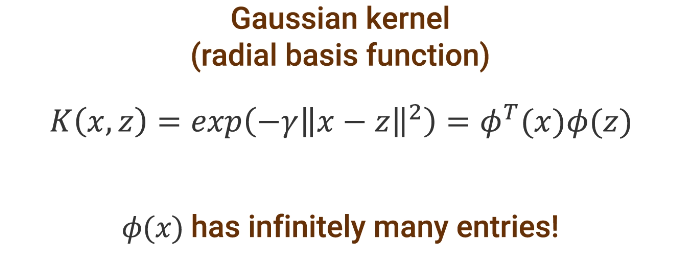

In [60]:
Kg = pairwise.rbf_kernel(train["X"], train["X"]) + 0.1 * np.eye(N)
rbf_model = LinearRegression().fit(Kg, train["Y"])

Either way of obtaining the evaluation kernel matrix is fine - reverse train and test, or keep as is and transpose it

In [67]:
ke_1 = pairwise.rbf_kernel(train["X"], test["X"]).T
ke_2 = pairwise.rbf_kernel(test["X"], train["X"])
np.allclose(ke_1, ke_2)

True

In [61]:
yhat_test_rbf = rbf_model.predict(pairwise.rbf_kernel(train["X"], test["X"]).T)
yhat_demo_rbf = rbf_model.predict(pairwise.rbf_kernel(X_demo, train["X"]))

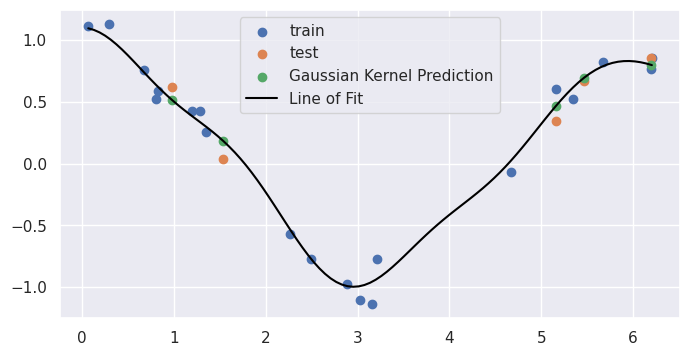

In [62]:
plt.scatter(train["X"], train["Y"], label="train")
plt.scatter(test["X"], test["Y"], label="test")
plt.scatter(test["X"], yhat_test_rbf, label="Gaussian Kernel Prediction")
plt.plot(X_demo, yhat_demo_rbf, label="Line of Fit", color="black")
plt.legend()

# Overview: Maximum Margin Classifier

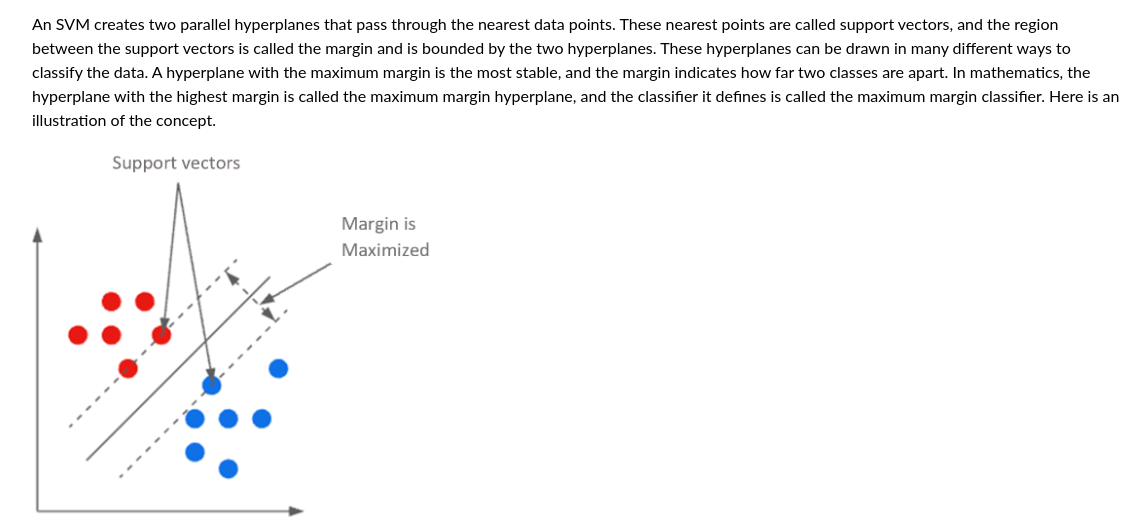

# 16.4 Maximum Margin Classifier

Choosing a decision boundary that maximizes the distance between it and the nearest point in the training set
- Considering the following data set with 2 classes and 2 features
- Which decision boundary (green line or red line) is better?
- The red line is better, because it is further from all samples in the training set

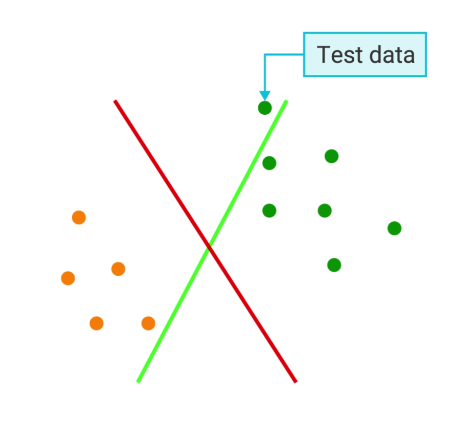

Terminology: **margin**
- Margin of a boundary is the perpindicular (orthogonal) distance from the boundary to the nearest point in the training set
- From all possible boundaries, the best is the one that maximimizes the margin
- The following graph shows distances between example points and candidate boundaries

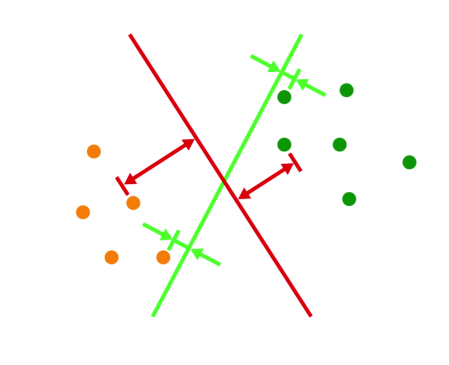

Returning to math model, use "beta" form of model
- With beta0 (the constant term) removed from the vector of betas

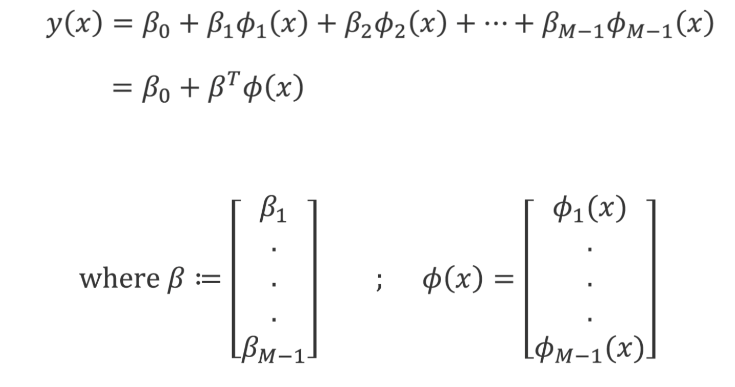

Why remove beta0 from the model? Allows for a nice intuitive understanding in terms of the following graph
- Beta is now the vector that is perpindicular to the decision boundary
- From the graph then, we want to maximize the dot product of the training data and beta
    - Compute dot product with all points and beta
    - Maximimize the smallest such product

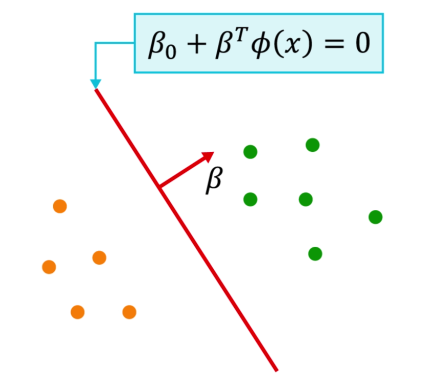

Following example shows that when taking 2 points on the decision boundary and fitting a line to it,
- We get a line (beta) that is perpindicular to the boundary

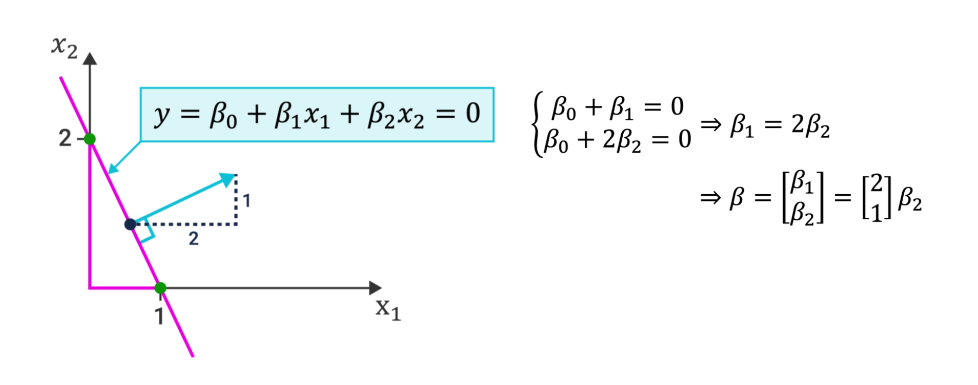

Take a 1-dimensional example
- Single feature phi1
- And 2 classes (green = +1, orange = -1)
- y(x) is a linear model in beta
- Decision boundary is the point where y = 0
- The slope of the line is beta1
- The margin is the horizontal distance from the decision point to the nearest data point

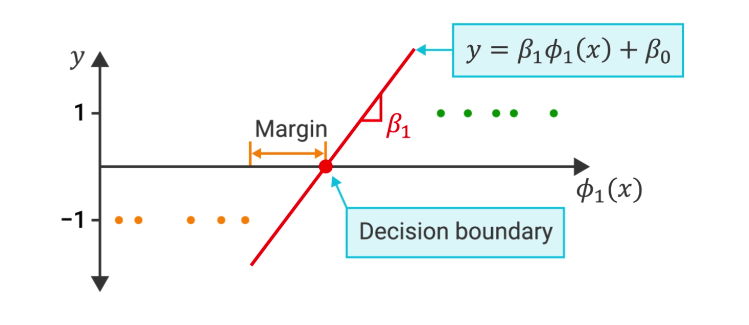

Here is the procedure for finding the best line
- First, extend boundaries from the orange data up and green data down
- And prohibit red line from going through these boundaries
- Written in math terms as follows
- This seems to exclude a horizontal line, for example

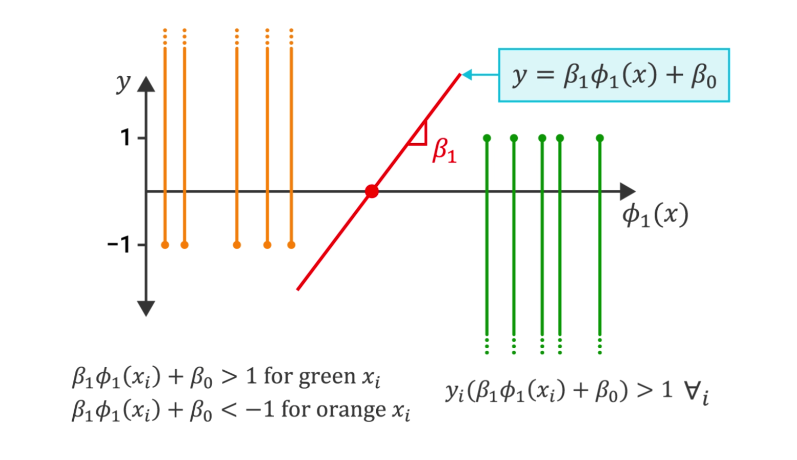

Resulting possible lines are shown below
- The red line is the best one, which is the one with the shallowest positive slope
- Minimal beta1

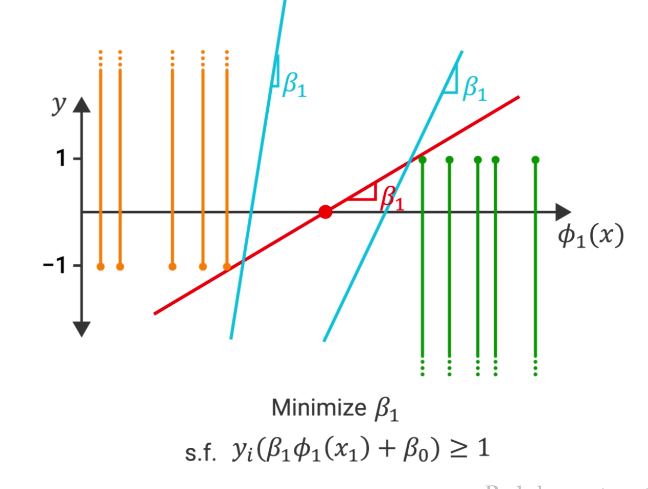

But what if the orange and green points were reversed on the x axis?
- Then you would want to have the shallowest negative slope
- Or in general, choose the smallest unsigned beta1 |beta1|

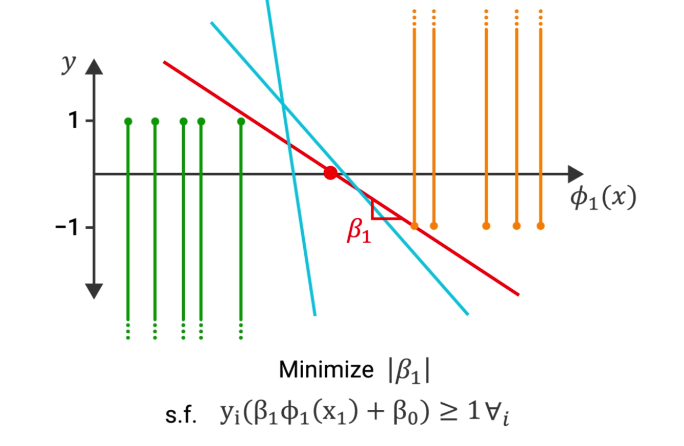

Even easier, minimize the 2-norm of beta
- Turns out to be convex function
- Which is great because gradient descent will find the global minimum always

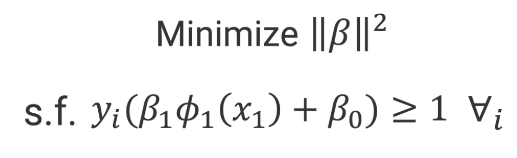

What follows is an example solution from sklearn
- Notice only 3 points determine the solution
- Why 3 and not 2?
    - I think because it happens that 2 oranges share the same minimum distance to the line
- Solid line = decision boundary
- Dashed lines = parallel to boundary but spaced by the margin
- No other points determine the solution and can be moved around anyway
    - Provided they do not enter the margin
    - At which point, those would then be the margin (boundary)-determining points
- These points which determine the boundary are called the **support vectors**

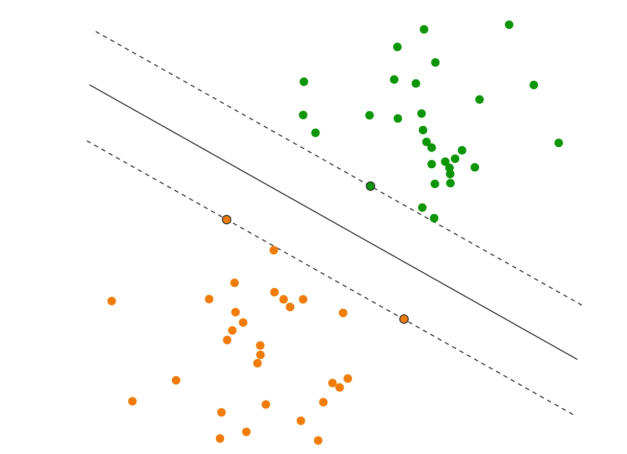

Nice feature of maximum margin classifier is its dependency on just these few points
- Makes it especially amenable to kernel method then
- Since recall that kernel requires ALL training points
    - Here ALL training points are just 3
    - The support vectors
- By comparison, for linear or logistic regression ALL training points means the entire training set
- Computationally prohibitive

Big gotcha
- MMC requires points to be non-overlapped
- Since the "rod constraints"...
    - The extended vertical lines from the data sets
- ... would have precluded all solutions

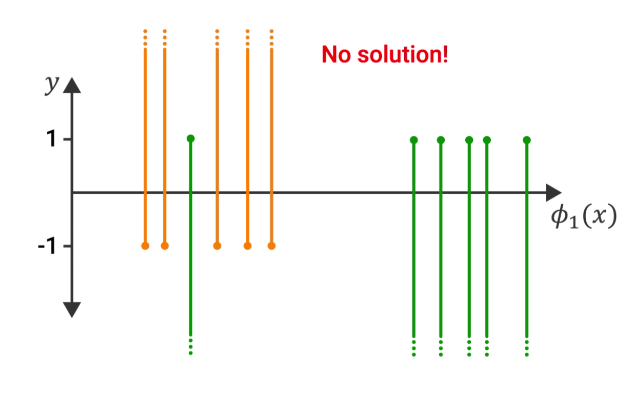

But a fix is in!
- Have to shift the overlapped point(s) such that a line separating the points becomes possible
- The shift amount per point is delta_i
    - In following example, delta_i = 0 for all but one i
- This gives rise to an additional term in the minimization problem
- Minimize not just the 2-norm of beta but also the sum of all shift values
    - Weighted by a new hyperparameter cost parameter C
    - Shouldn't it be sum of all |delta_i|?
    - Constraint shows it is non-negative though
- This problem remains convex

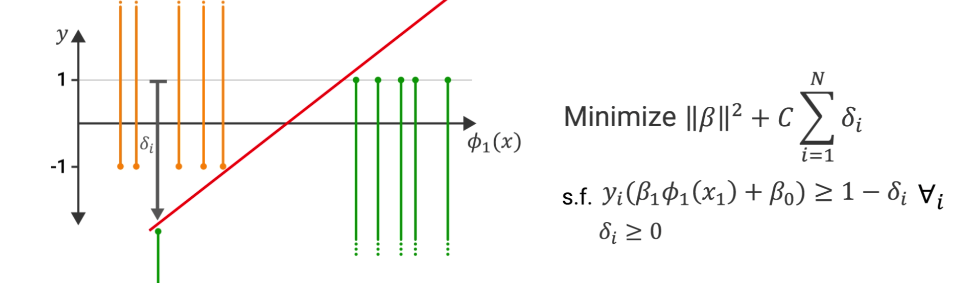

# Overview - Support Vector Machines

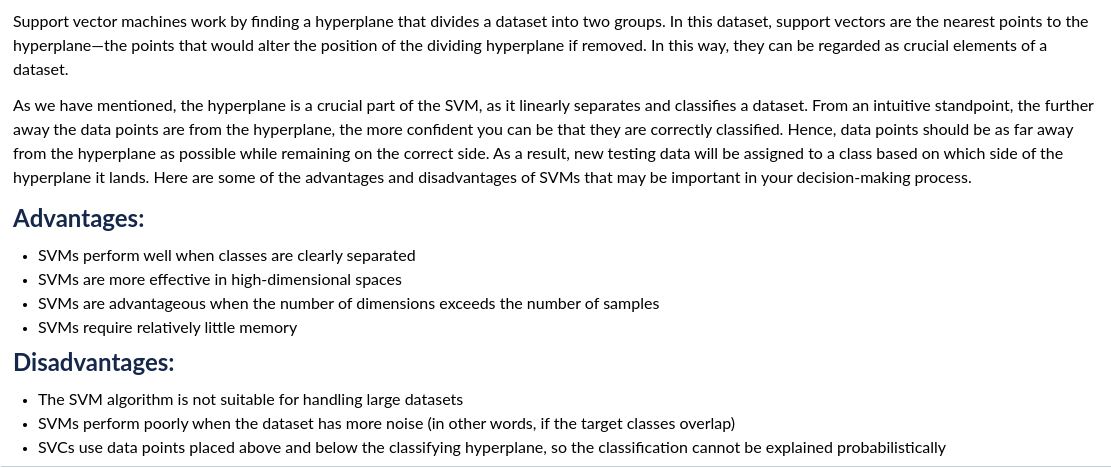